In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

## Data Loading

In [2]:
dataset = []

with open("../data/Export All HB-4 Mikrotes 3 09 Nov 24.csv", "r") as f:
    for line in f:
        line = f.readline().split("|")
        if len(line) < 10:
            continue

        signal_trunc = np.array([float(x) for x in line[6:]]) # / 65535.0 # 16 bit ADC

        dataset.append({
            "num": int(line[0]),
            "patient_name": line[1].lower().strip(),
            "hb": float(line[5]),
            "signal": signal_trunc,
            "signal_ln_trunc": np.around(np.log(signal_trunc)),
        })

In [3]:
df_gold = pd.read_csv("../data/gold-09-nov.csv").drop(columns=["phone"])
df_gold["name"] = df_gold["name"].str.lower().str.strip()
df_gold.head()

,name,hb_gold
0,shafa mulianti aisyah,12.2
1,saori arsy oktari,12.2
2,fatya adzkiya,13.0
3,eka wulandari,11.9
4,ambarsari as zahra,12.0


## EDA

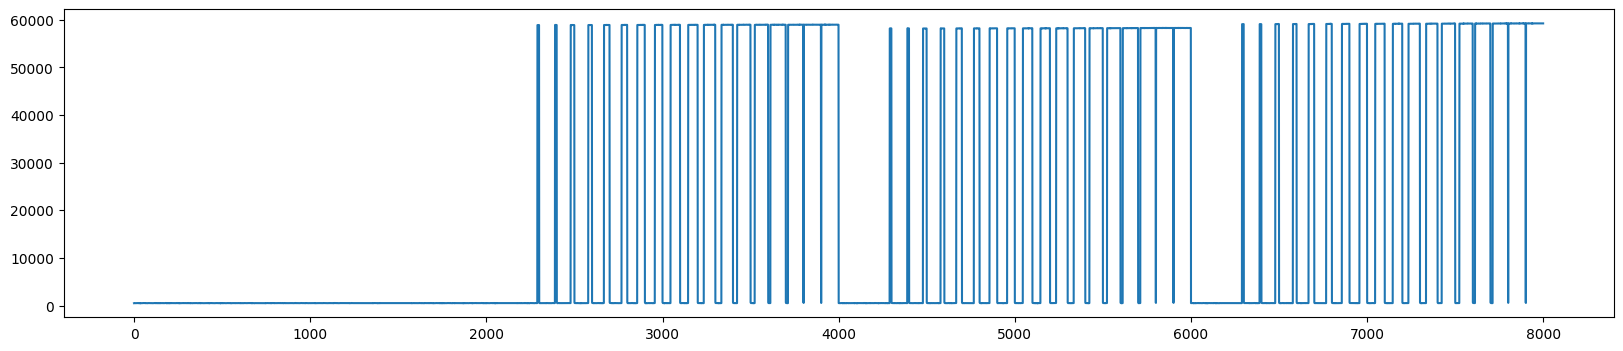

In [4]:
plt.figure(figsize=(20, 4))
plt.plot(range(dataset[0]["signal"].shape[0]), dataset[0]["signal"])

In [5]:
baseline = np.mean(dataset[0]["signal"][:2000])
segments = np.split(dataset[0]["signal"][2000:], 30)
baseline, len(segments), segments[0].shape

(np.float64(508.2235), 30, (200,))

In [6]:
dataset[0]["signal"][3944] - baseline

np.float64(58443.7765)

In [7]:
corrected_segments = np.array([segment - baseline for segment in segments]).ravel()
corrected_segments

array([ 8.77650000e+00, -9.22350000e+00, -1.22350000e+00, ...,
        5.87117765e+04,  5.87197765e+04,  5.87057765e+04])

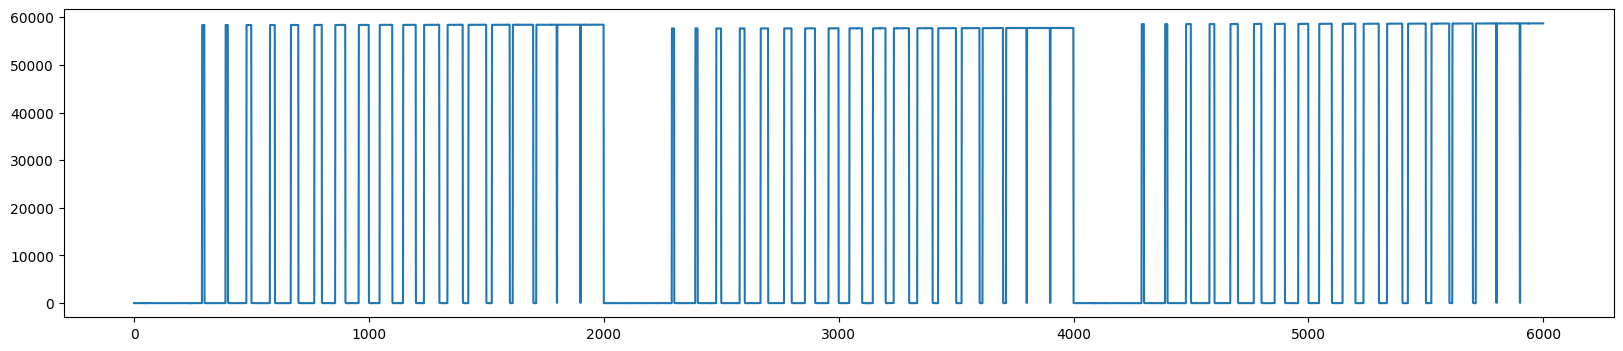

In [8]:
plt.figure(figsize=(20, 4))
plt.plot(range(corrected_segments.shape[0]), corrected_segments)

## Preprocessing

In [9]:
def derive_signal_features_stats(ds: list[dict]):
    derive_ds = []

    # process each row
    for proc in ds:
        baseline = np.mean(proc["signal"][:2000])
        segments = np.split(proc["signal"][2000:], 30)
        corrected_segments = np.array([segment - baseline for segment in segments]).ravel()

        # calculate signal statistics
        derive_ds.append({
            "patient_name": proc["patient_name"].lower().strip(),
            "hb": proc["hb"],
            # "signal_corrected": corrected_segments
            
            **{f"avg_{k}": v for k, v in zip(range(len(corrected_segments)), corrected_segments)}
        })

    return pd.DataFrame(derive_ds)

In [10]:
df_signal = derive_signal_features_stats(dataset)
df_signal.head()

,patient_name,hb,avg_0,avg_1,avg_2,avg_3,avg_4,avg_5,avg_6,avg_7,...,avg_5990,avg_5991,avg_5992,avg_5993,avg_5994,avg_5995,avg_5996,avg_5997,avg_5998,avg_5999
0,saori arsy oktari,13.96307,8.7765,-9.2235,-1.2235,-7.2235,2.7765,-9.2235,4.7765,-6.2235,...,58705.7765,58709.7765,58701.7765,58712.7765,58698.7765,58717.7765,58705.7765,58711.7765,58719.7765,58705.7765
1,eka wulandari,13.44660,0.9270,2.9270,14.9270,6.9270,-1.0730,-3.0730,-11.0730,-2.0730,...,58571.9270,58529.9270,58581.9270,58575.9270,58574.9270,58589.9270,58573.9270,58575.9270,58573.9270,58567.9270
2,wan maharani humaira,13.53031,-20.6240,-8.6240,-17.6240,-4.6240,-12.6240,5.3760,-6.6240,6.3760,...,58472.3760,58468.3760,58446.3760,58462.3760,58446.3760,58456.3760,58452.3760,58452.3760,58458.3760,58462.3760
3,hana ulil azmi,13.70974,11.1680,-1.8320,11.1680,-1.8320,2.1680,-1.8320,10.1680,-12.8320,...,58073.1680,58071.1680,58073.1680,58063.1680,58069.1680,58075.1680,58071.1680,58067.1680,58063.1680,58061.1680
4,onyx maxentia,14.95977,-13.0150,2.9850,-1.0150,-7.0150,-9.0150,-14.0150,-12.0150,-15.0150,...,58103.9850,58097.9850,58115.9850,58110.9850,58115.9850,58099.9850,58107.9850,58109.9850,58107.9850,58113.9850


In [11]:
df_all = df_signal.merge(df_gold, left_on="patient_name", right_on="name")
df_all.head()

,patient_name,hb,avg_0,avg_1,avg_2,avg_3,avg_4,avg_5,avg_6,avg_7,...,avg_5992,avg_5993,avg_5994,avg_5995,avg_5996,avg_5997,avg_5998,avg_5999,name,hb_gold
0,saori arsy oktari,13.96307,8.7765,-9.2235,-1.2235,-7.2235,2.7765,-9.2235,4.7765,-6.2235,...,58701.7765,58712.7765,58698.7765,58717.7765,58705.7765,58711.7765,58719.7765,58705.7765,saori arsy oktari,12.2
1,eka wulandari,13.44660,0.9270,2.9270,14.9270,6.9270,-1.0730,-3.0730,-11.0730,-2.0730,...,58581.9270,58575.9270,58574.9270,58589.9270,58573.9270,58575.9270,58573.9270,58567.9270,eka wulandari,11.9
2,wan maharani humaira,13.53031,-20.6240,-8.6240,-17.6240,-4.6240,-12.6240,5.3760,-6.6240,6.3760,...,58446.3760,58462.3760,58446.3760,58456.3760,58452.3760,58452.3760,58458.3760,58462.3760,wan maharani humaira,13.9
3,hana ulil azmi,13.70974,11.1680,-1.8320,11.1680,-1.8320,2.1680,-1.8320,10.1680,-12.8320,...,58073.1680,58063.1680,58069.1680,58075.1680,58071.1680,58067.1680,58063.1680,58061.1680,hana ulil azmi,12.7
4,onyx maxentia,14.95977,-13.0150,2.9850,-1.0150,-7.0150,-9.0150,-14.0150,-12.0150,-15.0150,...,58115.9850,58110.9850,58115.9850,58099.9850,58107.9850,58109.9850,58107.9850,58113.9850,onyx maxentia,13.5


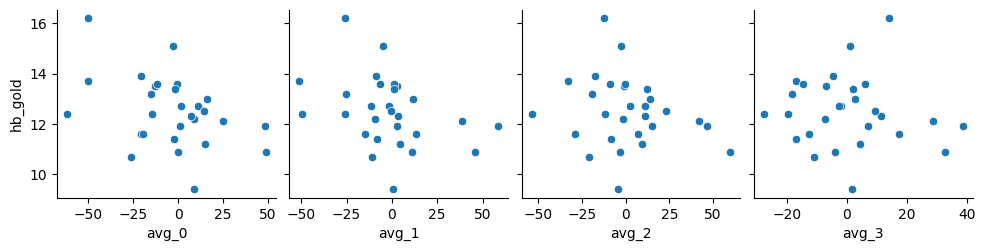

In [12]:
sns.pairplot(df_all, y_vars=["hb_gold"], x_vars=["avg_0", "avg_1", "avg_2", "avg_3"])
# sns.pairplot(df_all, y_vars=["hb_gold"])

In [13]:
dd = df_all.drop(columns=["patient_name", "name", "hb"], errors="ignore")
# sns.heatmap(dd.corr(), annot=True)
# sns.heatmap(dd.corr())

In [14]:
r_hb = dd.corr()[["hb_gold"]]
r_hb

,hb_gold
avg_0,-0.402926
avg_1,-0.347425
avg_2,-0.215527
avg_3,-0.092253
avg_4,-0.014462
...,...
avg_5996,-0.437181
avg_5997,-0.419617
avg_5998,-0.428939
avg_5999,-0.420664


In [15]:
r_hb.sort_values("hb_gold",ascending=False).to_csv("test.csv")

## Regressor

In [16]:
cols_corr = r_hb.sort_values("hb_gold",ascending=False).index.tolist()
cols = [
    *cols_corr[1:4],
    *cols_corr[-3:],
]
cols

['avg_906', 'avg_3024', 'avg_3216', 'avg_1118', 'avg_606', 'avg_1214']

In [17]:
# get X, y
X = df_all.drop(columns=["patient_name", "name", "hb", "hb_gold"], errors="ignore")[cols]
y = df_all["hb_gold"]

### Cross-Validation

In [18]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, r_regression
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [19]:
scores = cross_validate(DecisionTreeRegressor(), X, y, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error"])
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.002359,0.003800,-0.697826,-0.850000,-1.301667,-1.140906
1,0.002055,0.002682,0.355574,-0.833333,-0.880000,-0.938083
2,0.001727,0.002424,-1.509302,-1.533333,-3.596667,-1.896488
3,0.002244,0.002756,-1.906475,-1.240000,-1.616000,-1.271220
4,0.001721,0.003010,-0.217378,-1.700000,-4.702000,-2.168410


In [20]:
scores_df.mean()

fit_time                            0.002021
score_time                          0.002934
test_r2                            -0.795081
test_neg_mean_absolute_error       -1.231333
test_neg_mean_squared_error        -2.419267
test_neg_root_mean_squared_error   -1.483021
dtype: float64

### Hold-out

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
# reg = RandomForestRegressor(random_state=24)
reg = DecisionTreeRegressor()
# reg = LinearRegression()
reg.fit(X_train, y_train)

DecisionTreeRegressor()

<Axes: xlabel='hb_gold'>

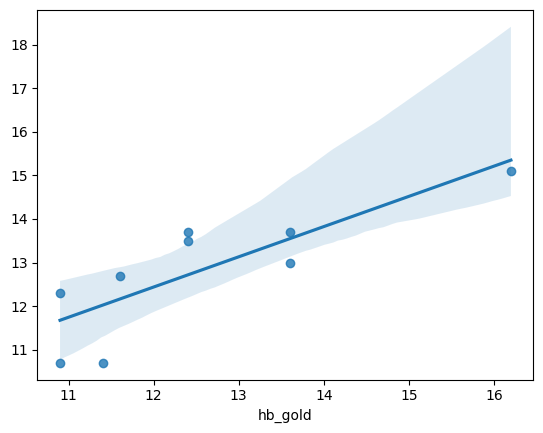

In [22]:
y_pred = reg.predict(X_test)
sns.regplot(x=y_test, y=y_pred)

In [23]:
y_pred = reg.predict(df_all[cols])
y_pred

array([12.2, 11.9, 13.9, 12.7, 13.5, 10.7, 13. , 13.7, 10.7, 11.2, 13.7,
       13. , 13.4, 12.7, 12.3,  9.4, 11.9, 11.6, 13.7, 13.2, 12.1, 12.3,
       13.5, 12.5, 12.7, 15.1, 15.1, 10.7])

In [30]:
df_c = pd.DataFrame({
    "hb_gold": df_all["hb_gold"],
    "hb_pred" : y_pred
}).sort_values("hb_gold")
df_c.head()

,hb_gold,hb_pred
15,9.4,9.4
27,10.7,10.7
21,10.9,12.3
8,10.9,10.7
9,11.2,11.2


R2 0.8439526898130485
R2 [[1.        0.9210143]
 [0.9210143 1.       ]]


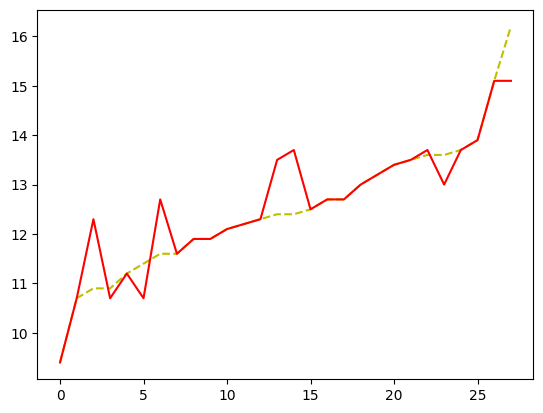

In [33]:
plt.plot(range(y_pred.shape[0]), df_c["hb_gold"], '--y')
plt.plot(range(y_pred.shape[0]), df_c["hb_pred"], 'r')

print("R2", r2_score(df_c["hb_gold"], df_c["hb_pred"]))
print("R2", np.corrcoef(df_c["hb_gold"], df_c["hb_pred"]))

R2 0.8439526898130485
R [[1.        0.9210143]
 [0.9210143 1.       ]]


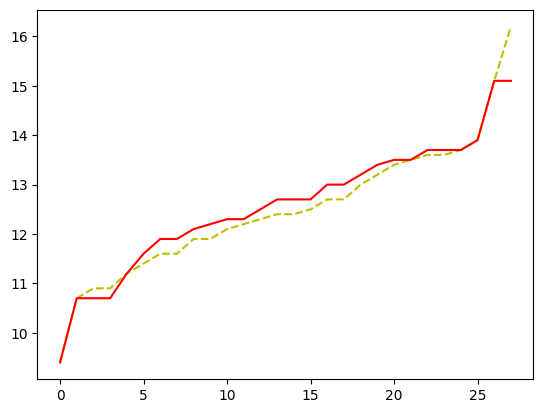

In [25]:
plt.plot(range(y_pred.shape[0]), df_all["hb_gold"].sort_values(), '--y')
plt.plot(range(y_pred.shape[0]), np.sort(y_pred), 'r')

print("R2", r2_score(df_all["hb_gold"], y_pred))
print("R", np.corrcoef(df_all["hb_gold"], y_pred))

## Top-K Feature Selection

In [26]:
reg_pipe = Pipeline(
    [
        ("reduce_dim", SelectKBest(r_regression, k=5)),
        ("classify", DecisionTreeRegressor()),
    ]
)

scores = cross_validate(reg_pipe, X, y, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error"])
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.003693,0.003281,0.597826,-0.483333,-0.308333,-0.555278
1,0.004072,0.006436,0.471522,-0.750000,-0.721667,-0.849510
2,0.005173,0.004622,-0.866279,-1.183333,-2.675000,-1.635543
3,0.011351,0.003642,-1.500000,-1.140000,-1.390000,-1.178983
4,0.007469,0.002669,-0.210128,-1.660000,-4.674000,-2.161944


In [27]:
scores_df.mean()

fit_time                            0.006351
score_time                          0.004130
test_r2                            -0.301412
test_neg_mean_absolute_error       -1.043333
test_neg_mean_squared_error        -1.953800
test_neg_root_mean_squared_error   -1.276251
dtype: float64